In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack


Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [3]:
for i in range(M):
    DCT[:, i] = sp.fftpack.dct(np.eye(M)[:, i], norm='ortho')


Generating the 1-D standard basis

In [4]:
for i in range(M):
    C[:, i] = np.eye(M)[:, i]


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

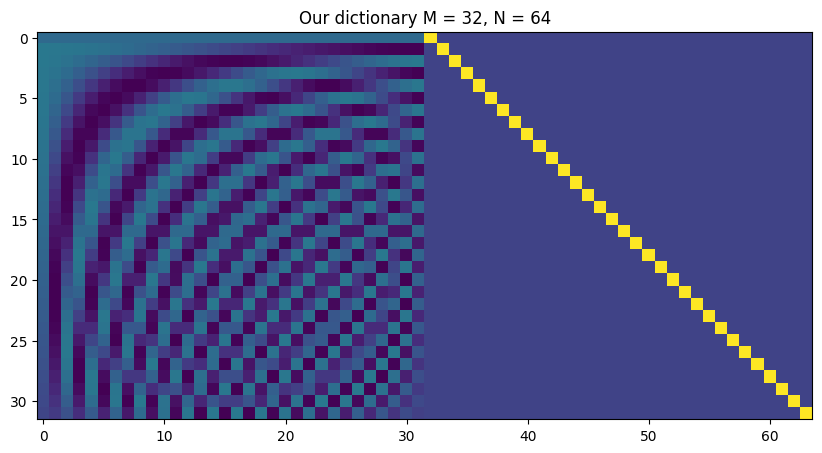

In [5]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [6]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [7]:
x0 = np.zeros(N)
for i in np.random.choice(N, L, replace=False):
    x0[i] = np.random.uniform(-1,1)

In [8]:
x0[x0 != 0]

array([ 0.38705953,  0.32317773, -0.81053285, -0.83418746,  0.58340902])



Choose spike location and update x0

In [9]:
spikeLocation = np.random.choice(range(N))
x0[spikeLocation] = 10

In [10]:
x0[x0 != 0]

array([ 0.38705953,  0.32317773, -0.81053285, -0.83418746, 10.        ])

Synthetize the corresponding signal in the signal domain and add noise


In [11]:
s0 = D @ x0
s = s0 + sigma_noise * np.random.randn(M)

Plot the sparse signal

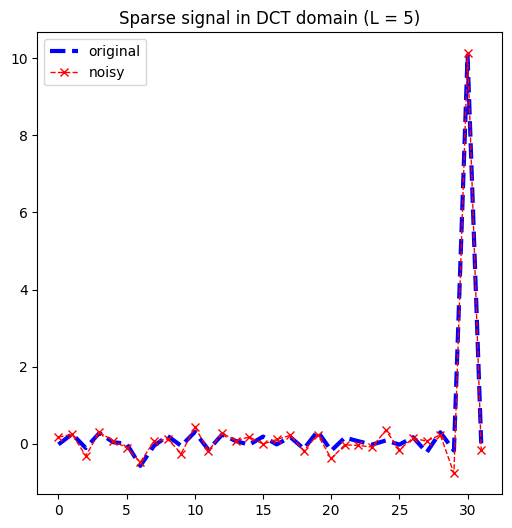

In [12]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [13]:
x_MP = np.zeros(N)
r = s.copy()
l = 1

#initialize the norm of the resiudal (components not represented by the coefficients)
resNorm = np.linalg.norm(r)

MINIMUM_RES_NORM = 0.1

MP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [14]:
while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:
  print(f'Iteration {l} - residual norm: {resNorm:.2f}')
  # SWEEP STEP: look for the column of D that matches best with the current residual
  # compute the projection of the residual w.r.t. each column of D
  e = np.zeros(N)
  for j in range(N):
    dj = D[:, j]
    e[j] = np.abs(np.dot(r.T, dj))**2 / np.linalg.norm(dj)**2

  # find the column of D that matches best with the residual
  jStar = np.argmax(e)
  
  # UPDATE the jStar coefficient by adding the new component dj' r / || dj ||^2
  projection_scalar = np.dot(r.T, D[:, jStar]) / np.linalg.norm(D[:, jStar])**2
  x_MP[jStar] += projection_scalar
  
  # update the residual by removing the component we have just represented
  r -= projection_scalar * D[:, jStar]  # subtract the matched component from the residual

  l += 1

  # update the norm of the residual
  resNorm = np.linalg.norm(r)

Iteration 1 - residual norm: 10.23
Iteration 2 - residual norm: 1.44
Iteration 3 - residual norm: 1.17
Iteration 4 - residual norm: 1.01
Iteration 5 - residual norm: 0.83


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [15]:
s_hat_MP = D @ x_MP

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [16]:
resNorm_MP = np.linalg.norm(s - s_hat_MP)


Show the result

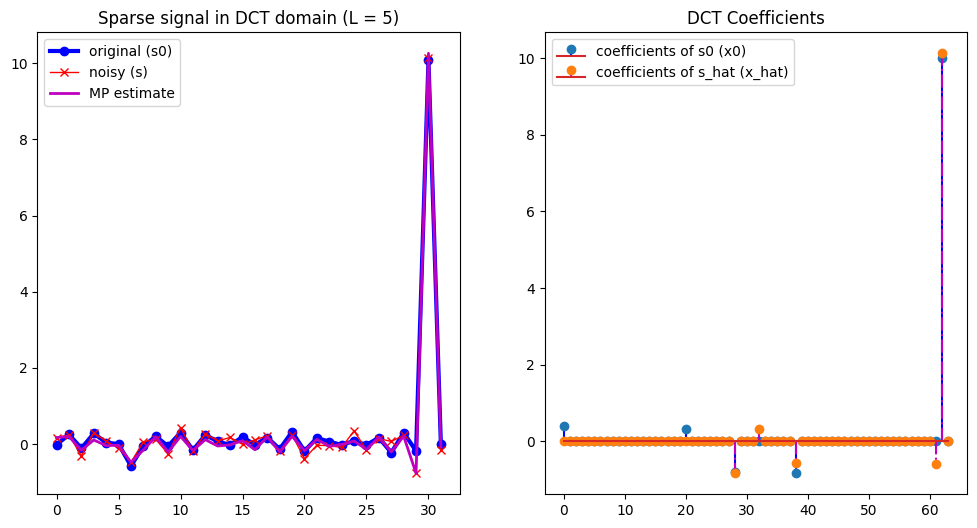

In [17]:
LN_WDT = 2
MRK_SZ = 10

_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

